# GUC Clustering Project 

**Objective:** 
The objective of this project teach students how to apply clustering to real data sets

The projects aims to teach student: 
* Which clustering approach to use
* Compare between Kmeans, Hierarchal, DBScan, and Gaussian Mixtures  
* How to tune the parameters of each data approach
* What is the effect of different distance functions (optional) 
* How to evaluate clustering approachs 
* How to display the output
* What is the effect of normalizing the data 

Students in this project will use ready-made functions from Sklearn, plotnine, numpy and pandas 
 



Running this project require the following imports 

In [20]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn.preprocessing as prep
from sklearn.datasets import make_blobs
from plotnine import *   
from sklearn.preprocessing import MaxAbsScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score

%matplotlib inline
np.random.seed(4615349)

In [21]:
# helper function that allows us to display data in 2 dimensions an highlights the clusters
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'  #List colors
    alpha = 0.5  #color obaque
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

## Multi Blob Data Set 
* The Data Set generated below has 6 cluster with varying number of users and varing densities
* Cluster the data set below using 



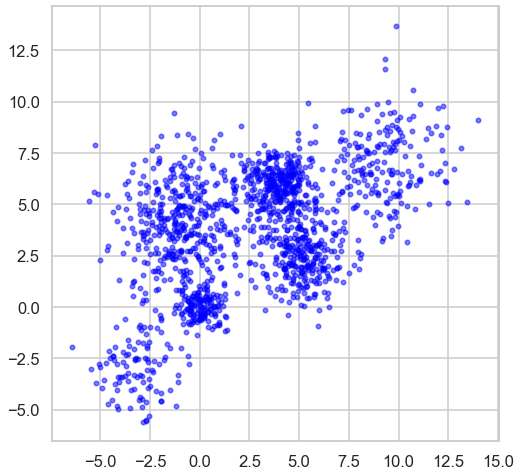

In [22]:
plt.rcParams['figure.figsize'] = [8,8]
sns.set_style("whitegrid")
sns.set_context("talk")

n_bins = 6  
centers = [(-3, -3), (0, 0), (5,2.5),(-1, 4), (4, 6), (9,7)]
Multi_blob_Data, y = make_blobs(n_samples=[100,150, 300, 400,300, 200], n_features=2, cluster_std=[1.3,0.6, 1.2, 1.7,0.9,1.7],
                  centers=centers, shuffle=False, random_state=42)
display_cluster(Multi_blob_Data)

### Kmeans 
* Use Kmeans with different values of K to cluster the above data 
* Display the outcome of each value of K 
* Plot distortion function versus K and choose the approriate value of k 
* Plot the silhouette_score versus K and use it to choose the best K 
* Store the silhouette_score for the best K for later comparison with other clustering techniques. 

best : {'model': KMeans(n_clusters=6), 'Y': array([1, 1, 1, ..., 4, 0, 4], dtype=int32), 'silhouette_score': 0.48609408962389}


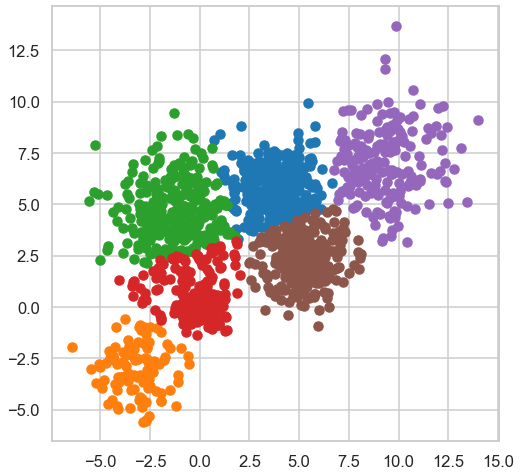

In [23]:
def kmeans(data,silhouette_plot=False,elbow_plot=False,plot=False):
    
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    import operator

    ks = [2, 3, 4, 5, 6]
    results = {}

    for k in ks:
        kmeans = KMeans(n_clusters=k)
        ys = kmeans.fit_predict(data)
        results[k] = {'model': kmeans, "Y" : ys,'silhouette_score': silhouette_score(data, kmeans.labels_)}

    if silhouette_plot:

        si = [i["silhouette_score"] for i in results.values()]
        plt.plot(results.keys(),si)
        plt.show()

    if elbow_plot:

        from yellowbrick.cluster import KElbowVisualizer

        visualizer = KElbowVisualizer(KMeans, k=(1, 10), timings=False)
        visualizer.fit(data)
        visualizer.show()

    tmp  = [r for r in results.values() if r["silhouette_score"] is not None]
    tmp.sort(key=operator.itemgetter('silhouette_score'))
    best = tmp[-1]
    print("best :" ,best)

    if plot:
        if len(data[0]) <= 2:

            ys = tmp[-1]["Y"]
            set_cluster = set(ys)

            for c in set_cluster:
                plot_points = np.array([list(data[idx]) for idx,val in enumerate(ys) if val == c])
                plot_points = np.transpose(plot_points)
                plt.scatter(plot_points[0],plot_points[1])

            plt.show()

    return results

r = kmeans(Multi_blob_Data,plot=True)


### Hierarchal Clustering
* Use AgglomerativeClustering function to  to cluster the above data 
* In the  AgglomerativeClustering change the following parameters 
    * Affinity (use euclidean, manhattan and cosine)
    * Linkage( use average and single )
    * Distance_threshold (try different)
* For each of these trials plot the Dendograph , calculate the silhouette_score and display the resulting clusters  
* Find the set of paramters that would find result in the best silhouette_score and store this score for later comparison with other clustering techniques. 
* Record your observation 

In [24]:
def plot_dendrogram(model, **kwargs):
    
    from scipy.cluster.hierarchy import dendrogram

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

def hierarchal(data,silhouette_plot=False,dendro=False):

    from sklearn.cluster import AgglomerativeClustering
    from sklearn.metrics import silhouette_score
    import operator

    affinities = ['euclidean', 'manhattan', 'cosine']
    linkages = ['average', 'single']
    distance_thresholds = [None, 2, 4, 6]

    results = {}
    for affinity in affinities:
        for linkage in linkages:
            for distance_threshold in distance_thresholds:
                if distance_threshold is None:
                    model = AgglomerativeClustering(n_clusters=3, affinity=affinity, linkage=linkage)
                else:
                    model = AgglomerativeClustering(n_clusters=None,affinity=affinity, linkage=linkage,
                                                    distance_threshold=distance_threshold)
                model.fit(Multi_blob_Data)
                if len(set(model.labels_)) == 1:
                    results[(affinity, linkage, distance_threshold)] = {'model': model,
                                                                    'silhouette_score': None}
                else:
                    results[(affinity, linkage, distance_threshold)] = {'model': model,
                                                                    'silhouette_score': silhouette_score(Multi_blob_Data, model.labels_)}
                    
    tmp  = [r for r in results.values() if r["silhouette_score"] is not None]
    tmp.sort(key=operator.itemgetter('silhouette_score'))
    best = tmp[-1]
    print("best :" , best)

    if dendro:
        model = tmp[-1]["model"]
        plot_dendrogram(model)

    if silhouette_plot:
        si = [i["silhouette_score"] for i in results.values()]
        plt.plot(results.keys(),si)
        plt.show()

    return results

### DBScan
* Use DBScan function to  to cluster the above data 
* In the  DBscan change the following parameters 
    * EPS (from 0.1 to 3)
    * Min_samples (from 5 to 25)
* Plot the silhouette_score versus the variation in the EPS and the min_samples
* Plot the resulting Clusters in this case 
* Find the set of paramters that would find result in the best silhouette_score and store this score for later comparison with other clustering techniques. 
* Record your observations and comments 

best : {'model': DBSCAN(eps=2.900000000000001, min_samples=24), 'Y': array([ 0,  0,  0, ..., -1,  0,  0]), 'silhouette_score': 0.4685207355522043}


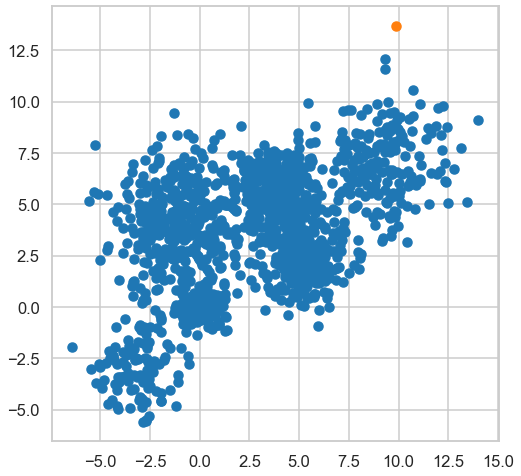

In [35]:
def dbscan(data,plot=False):
    
    from sklearn.cluster import DBSCAN
    import operator

    EPS = np.arange(0.1, 3.1, 0.2)
    Min_samples = np.arange(5,25,1)

    results={}
    for e in EPS:
        for s in Min_samples:
            dbscan = DBSCAN(eps=e, min_samples=s)
            ys = dbscan.fit_predict(data)
            if len(set(dbscan.labels_)) == 1:
                results[(e,s)]={"model":dbscan,"Y":ys,"silhouette_score":None}
            else:
                results[(e,s)]={"model":dbscan,"Y":ys,"silhouette_score":silhouette_score(data,dbscan.labels_)}

    import operator

    tmp  = [r for r in results.values() if r["silhouette_score"] is not None]
    tmp.sort(key=operator.itemgetter('silhouette_score'))
    best = tmp[-1]
    print("best :" , best)

    if plot:
        if len(data[0]) <= 2:
            
            ys = tmp[-1]["Y"]
            set_cluster = set(ys)

            for c in set_cluster:
                plot_points = np.array([list(data[idx]) for idx,val in enumerate(ys) if val == c])
                plot_points = np.transpose(plot_points)
                plt.scatter(plot_points[0],plot_points[1])

            plt.show()

    return results

r = dbscan(Multi_blob_Data,True)

### Gaussian Mixture
* Use GaussianMixture function to cluster the above data 
* In GMM change the covariance_type and check the difference in the resulting proabability fit 
* Use a 2D contour plot to plot the resulting distribution (the components of the GMM) as well as the total Gaussian mixture 

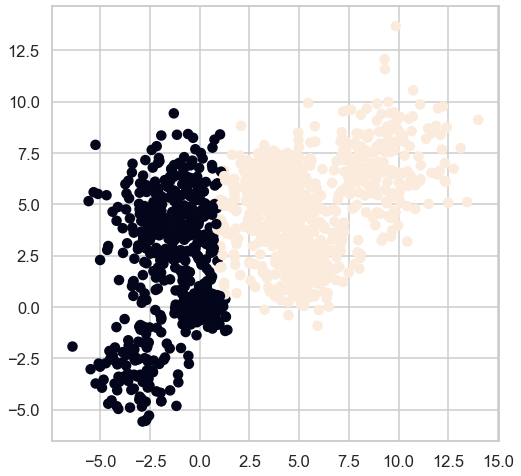

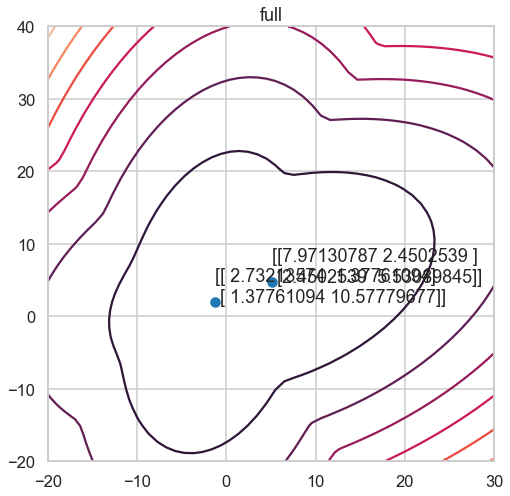

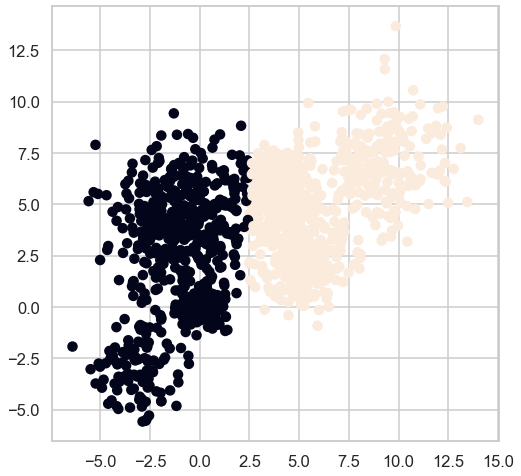

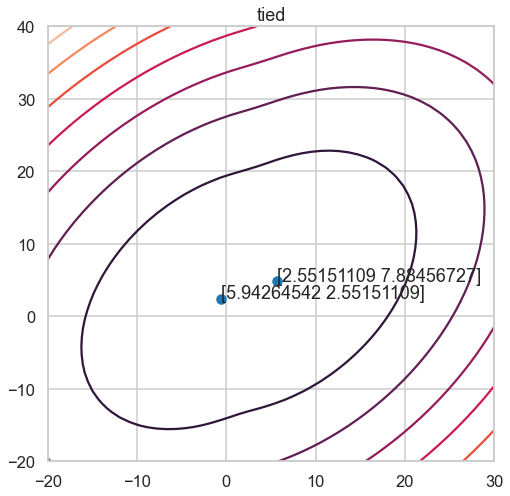

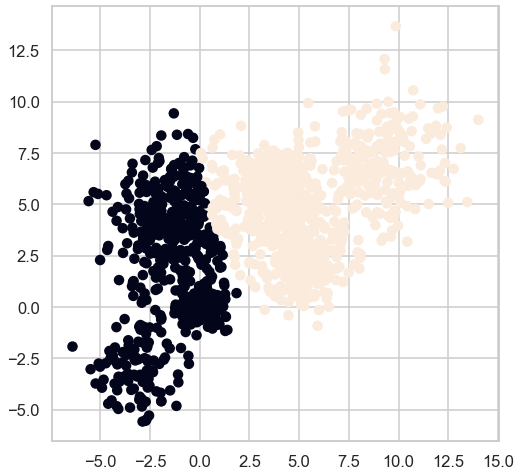

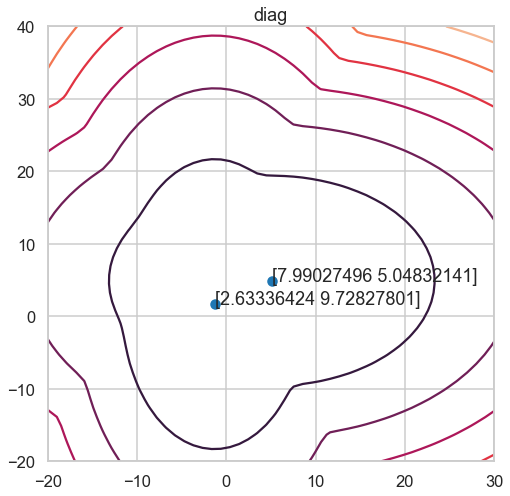

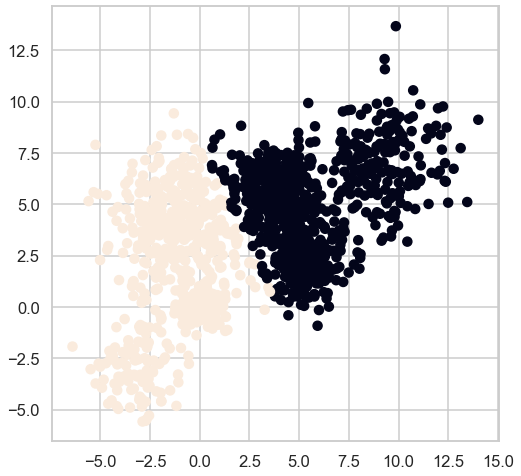

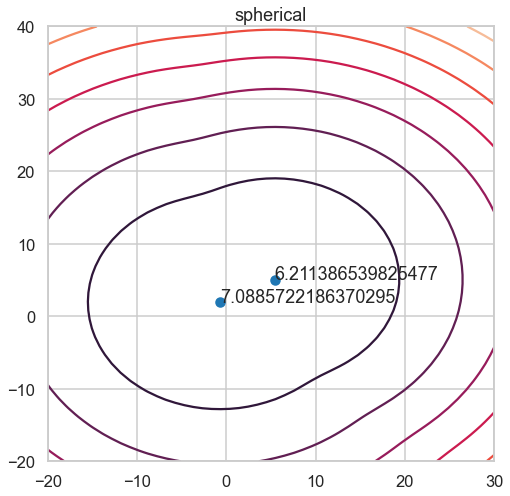

In [26]:
def gm(data):

    from sklearn import mixture

    covariance_type = ["full","tied","diag","spherical"]
    results = {}

    for cov in covariance_type:
        gmm =  mixture.GaussianMixture(n_components = 2,covariance_type=cov)
        ys = gmm.fit_predict(data)
        results[cov] = {"model":gmm}

        if len(data[0]) <= 2:
            plt.scatter(data[:,0],data[:,1],c=ys)
            plt.show()
            
            x = np.linspace(-20.0, 30.0)
            y = np.linspace(-20.0, 40.0)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = - gmm.score_samples(XX)
            Z = Z.reshape(X.shape)

            plt.contour(X, Y, Z)
            cn = np.transpose(gmm.means_)
            plt.scatter(cn[0],cn[1])

            for i in range(len(cn)):
                plt.text(cn[0][i], cn[1][i], gmm.covariances_[i])
                
            plt.title(cov)
            plt.show()
    return results

r = gm(Multi_blob_Data)

#### Principal Conponent analysis

In [ ]:
def pca(x,n=2):
    pca = PCA(n_components=n)
    return pca.fit_transform(x)

## iris data set 
The iris data set is test data set that is part of the Sklearn module 
which contains 150 records each with 4 features. All the features are represented by real numbers 

The data represents three classes 


In [27]:
from sklearn.datasets import load_iris
iris_data = load_iris()["data"]

* Repeat all the above clustering approaches and steps on the above data 
* Normalize the data then repeat all the above steps 
* Compare between the different clustering approaches 

### kmeans

In [28]:
r = kmeans(iris_data)

best : {'model': KMeans(n_clusters=2), 'Y': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'silhouette_score': 0.6810461692117462}


### DbScan

In [29]:
r = hierarchal(iris_data)

best : {'model': AgglomerativeClustering(distance_threshold=6, linkage='average',
                        n_clusters=None), 'silhouette_score': 0.4307906732655957}


### GMM

In [30]:
gm(iris_data)

{'full': {'model': GaussianMixture(n_components=2)},
 'tied': {'model': GaussianMixture(covariance_type='tied', n_components=2)},
 'diag': {'model': GaussianMixture(covariance_type='diag', n_components=2)},
 'spherical': {'model': GaussianMixture(covariance_type='spherical', n_components=2)}}

## Customer dataset
Repeat all the above on the customer data set 

In [31]:
import pandas as pd

customer = pd.read_csv("./Customer data.csv",index_col="ID")
customer.reset_index(drop=True, inplace=True)
customer['Income'] = MaxAbsScaler().fit_transform(customer['Income'].values.reshape(-1, 1))
customer['Age'] = MaxAbsScaler().fit_transform(customer['Age'].values.reshape(-1, 1))

In [32]:
customer

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,0.881579,2,0.402988,1,2
1,1,1,0.289474,1,0.487364,1,2
2,0,0,0.644737,1,0.288366,0,0
3,0,0,0.592105,1,0.554573,1,1
4,0,0,0.697368,1,0.481733,1,1
...,...,...,...,...,...,...,...
1995,1,0,0.618421,1,0.399287,0,0
1996,1,1,0.355263,1,0.380600,1,0
1997,0,0,0.407895,0,0.279283,0,0
1998,1,1,0.315789,1,0.316676,0,0


In [39]:
r_k = kmeans(customer)

best : {'model': KMeans(n_clusters=2), 'Y': array([0, 0, 1, ..., 1, 1, 1], dtype=int32), 'silhouette_score': 0.33367170175108457}


In [36]:
r_db = dbscan(customer)

best : {'model': DBSCAN(eps=0.9000000000000001), 'Y': array([ 0,  1,  2, ..., 21,  9, 21]), 'silhouette_score': 0.8330888236776489}


In [ ]:
r_gmm = gm(customer)